In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm


In [163]:
saving_path = pathlib.Path("results")


def load_results(method):
    # assert method in ["euclid", "euclid_biased" "so2"]

    method_path = saving_path / method

    start_noise = np.load(method_path / "start_noise.npy")
    losses = np.load(method_path / "losses.npy")
    angle_abs_errors = np.load(method_path / "angle_abs_errors.npy")  # / np.pi * 180
    return start_noise, losses, angle_abs_errors

In [165]:
start_noise_euclid, losses_euclid, angle_abs_errors_euclid = load_results("euclid")
start_noise_euclid_biased, losses_euclid_biased, angle_abs_errors_euclid_biased = load_results(
    "euclid_biased_inference"
)
start_noise_so2, losses_so2, angle_abs_errors_so2 = load_results("so2")
# start_noise_so2_forward, losses_so2_forward, angle_abs_errors_so2_forward = load_results("so2_forward")

In [180]:
print("---- ---- ----")
print(f"Euclid\t\t{angle_abs_errors_euclid.mean()}")
print(f"Euclid Biased\t{angle_abs_errors_euclid_biased.mean()}")
print(f"SO(2)\t\t{angle_abs_errors_so2.mean()}")


---- ---- ----
Euclid		0.09337110072374344
Euclid Biased	0.07293790578842163
SO(2)		0.21620263159275055


In [167]:
print(angle_abs_errors_euclid.max())
print(angle_abs_errors_euclid_biased.max())
print(angle_abs_errors_so2.max())

print(sorted(angle_abs_errors_euclid)[-5:])
print(sorted(angle_abs_errors_euclid_biased)[-5:])
print(sorted(angle_abs_errors_so2)[-5:])

0.45358658
0.11835775
0.6584516
[0.4232169, 0.4315568, 0.44033593, 0.4413834, 0.45358658]
[0.118357055, 0.11835728, 0.11835745, 0.11835758, 0.11835775]
[0.65130615, 0.65507084, 0.6562489, 0.6569219, 0.6584516]


In [168]:
max_angle = 0.65 # in deg

Text(0.5, 0.98, 'Histogram of Angle Errors')

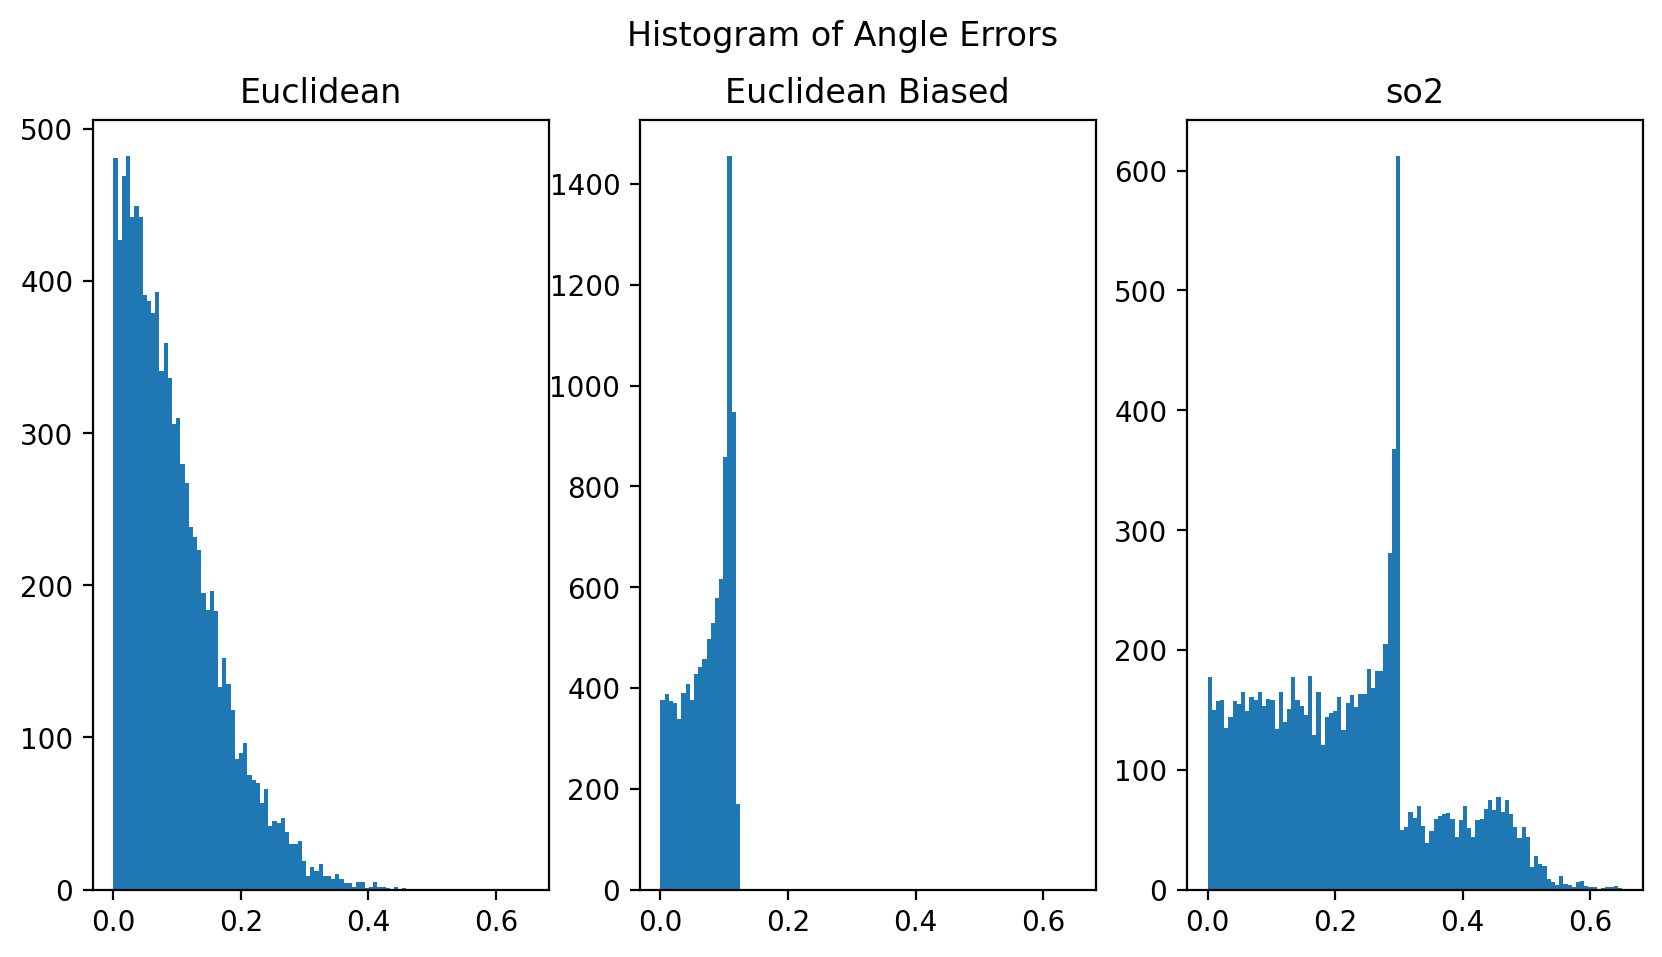

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=200, figsize=(10, 5))

bins = np.linspace(0., max_angle, 100)
axes[0].hist(angle_abs_errors_euclid, bins=bins)
axes[0].set_title("Euclidean")
axes[1].hist(angle_abs_errors_euclid_biased, bins=bins)
axes[1].set_title("Euclidean Biased")
axes[2].hist(angle_abs_errors_so2, bins=bins)
axes[2].set_title("so2")
fig.suptitle("Histogram of Angle Errors")

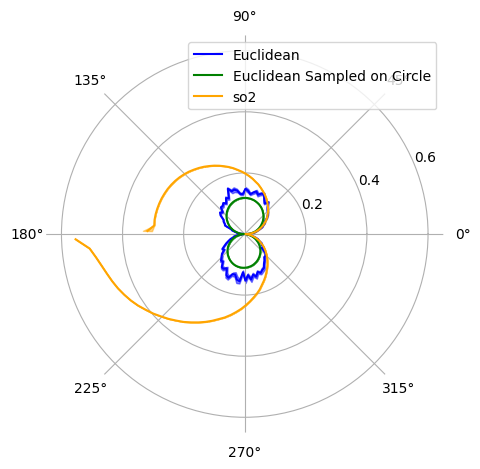

In [173]:
bins = np.linspace(-np.pi, np.pi, 102, endpoint=True)
bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2

def get_mean_var(start_noise, angle_abs_errors):
    start_noise_angle = np.arctan2(start_noise[:, 1], start_noise[:, 0])

    digitized = np.digitize(start_noise_angle, bins)
    bin_means = np.array([angle_abs_errors[digitized == i].mean() for i in range(1, len(bins))])
    bin_var = np.array([angle_abs_errors[digitized == i].var() for i in range(1, len(bins))])

    return bin_means, bin_var


bin_means_euclid, bin_var_euclid = get_mean_var(start_noise_euclid, angle_abs_errors_euclid)
bin_means_euclid_biased, bin_var_euclid_biased = get_mean_var(
    start_noise_euclid_biased, angle_abs_errors_euclid_biased
)
bin_means_so2, bin_var_so2 = get_mean_var(start_noise_so2[:, :, 0], angle_abs_errors_so2)


fig, ax = plt.subplots(subplot_kw=dict(polar=True))
alpha = 0.5
ax.plot(bin_centers, bin_means_euclid, label="Euclidean", color="blue")
ax.fill_between(
    bin_centers,
    bin_means_euclid - bin_var_euclid,
    bin_means_euclid + bin_var_euclid,
    alpha=alpha,
    edgecolor="blue",
    facecolor="blue",
)

ax.plot(bin_centers, bin_means_euclid_biased, label="Euclidean Sampled on Circle", color="green")
ax.fill_between(
    bin_centers,
    bin_means_euclid_biased - bin_var_euclid_biased,
    bin_means_euclid_biased + bin_var_euclid_biased,
    alpha=alpha,
    edgecolor="green",
    facecolor="green",
)

ax.plot(bin_centers, bin_means_so2, label="so2", color="orange")
ax.fill_between(
    bin_centers,
    bin_means_so2 - bin_var_so2,
    bin_means_so2 + bin_var_so2,
    alpha=alpha,
    edgecolor="orange",
    facecolor="orange",
)

ax.set_ylim(0, max_angle)
ax.set_yticks([0.2, 0.4, 0.6])  # Hide the y-axis ticks
ax.spines['polar'].set_visible(False)  # Hide the polar axis line
ax.legend()
fig.tight_layout()
plt.show()

In [198]:
def plot_heatmap(ax, start_noise, angle_abs_errors, limit=None):
    B = start_noise.shape[0]
    assert start_noise.shape[1] == 2 and angle_abs_errors.shape == (B,)

    bin_plot = ax.hexbin(
        start_noise[:, 0],
        start_noise[:, 1],
        C=angle_abs_errors,
        vmin=0,
        vmax=max_angle,
        cmap=cm.jet,
        gridsize=50,
        # bins=None,
    )
    if not limit is None:
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
    ax.scatter(1, 0, marker="x", c="red", s=50, linewidths=3)
    return bin_plot

/tmp/ipykernel_4189691/1936630390.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


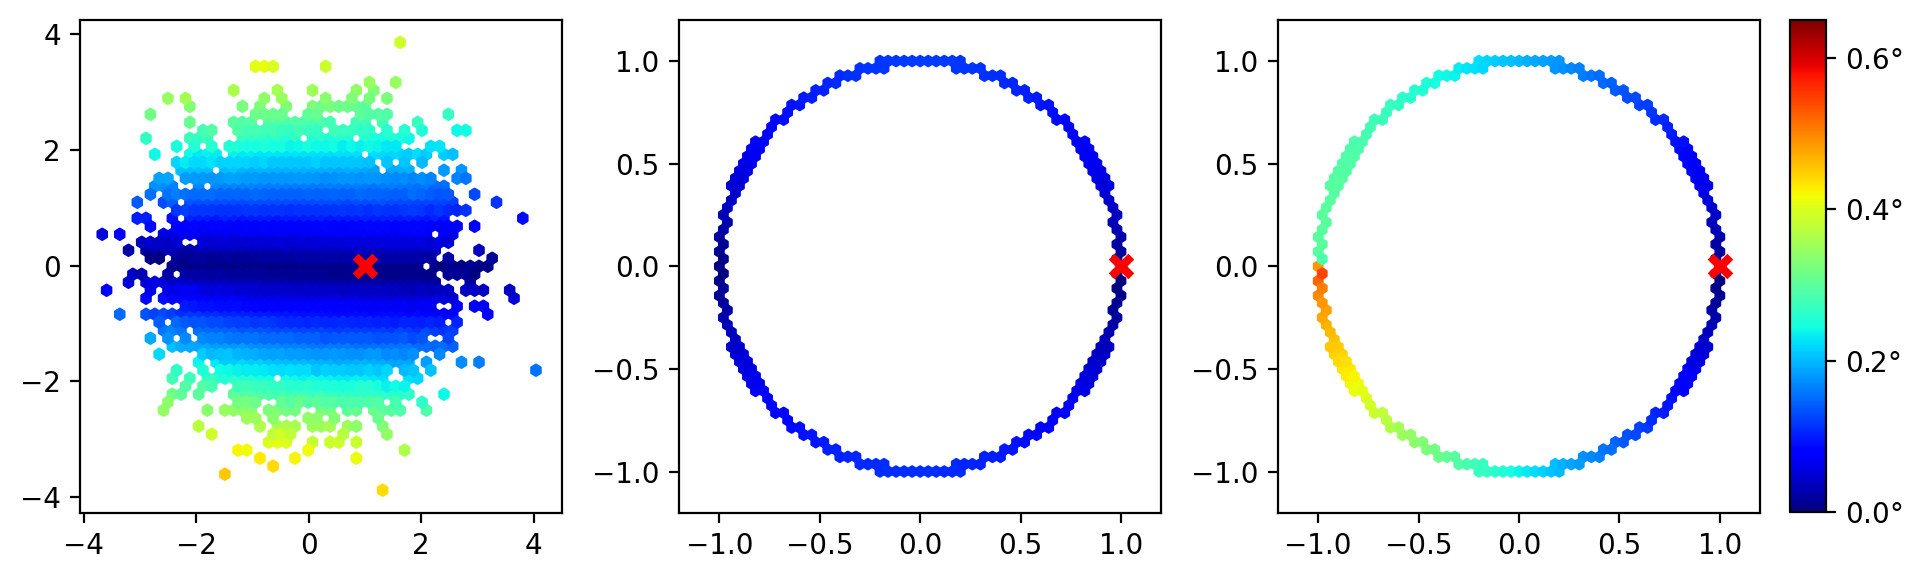

In [199]:
ncols = 3
limit = 4.0

fig, axes = plt.subplots(nrows=1, ncols=ncols, dpi=200, figsize=(3 * ncols, 3))
current_ax = 0

start_noise_euclid_normalized = start_noise_euclid / np.linalg.norm(
    start_noise_euclid, axis=-1, keepdims=True
)
bin_plot_euclid = plot_heatmap(
    axes[current_ax],
    start_noise_euclid,
    # start_noise_euclid_normalized,
    angle_abs_errors_euclid,
    # limit=limit
)
# axes[current_ax].set_title("Euclidean Formulation")

current_ax += 1
bin_plot_euclid = plot_heatmap(
    axes[current_ax],
    # start_noise_euclid_normalized,
    start_noise_euclid_biased,
    angle_abs_errors_euclid_biased,
    limit=1.2,
)
# axes[current_ax].set_title("Euclidean Sampled on Circle")

current_ax += 1
bin_plot_so2 = plot_heatmap(
    axes[current_ax], start_noise_so2[:, :, 0], angle_abs_errors_so2, limit=1.2
)
# axes[current_ax].set_title("SO(2) Formulation")

# bin_plot_so2_forward = plot_heatmap(axes[3], start_noise_so2_forward[:, :, 0], angle_abs_errors_so2_forward)
# axes[3].set_title("so2_forward")

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.13, 0.02, 0.82])
# ticks = np.linspace(0.0, max_angle, 6)
ticks = [0.0, 0.2, 0.4, 0.6]
cbar = fig.colorbar(bin_plot_so2, ax=axes.ravel(), cax=cbar_ax, ticks=ticks)
cbar.ax.set_yticklabels([rf"${tick}\degree$" for tick in ticks])  # vertically oriented colorbar

fig.tight_layout()
fig.savefig("toy_example.pdf", bbox_inches="tight")